# Hotspot propensity observed vs expected from Fig 4D, 4E and 4F

In [1]:
from collections import defaultdict
import json

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [3]:
sigs_color = {
'SBS1': '#1e79baff',
 'SBS2': '#ff9896ff',
 'SBS3': '#f6c200ff', 
 'SBS4': '#00a572ff', 
 'SBS5': '#7ebdeaff',
 'SBS7a': '#8c564bff', 
 'SBS7b': '#c49c94ff',
 'SBS8': '#3dbe3dff',
 'SBS13': '#d62728ff',
 'SBS17a': '#ffbb78ff',
 'SBS17b': '#ff8921ff', 
 'SBS18': '#9467bdff',
 'SBS40': '#c2e0f5ff', 
 'SBS93': '#c5b0d5ff'
}

In [4]:
data_dir = '../../../data'

### Load data

- Observed hotspot propensity using 30000 total mutations.
- Expected hotspot propensity across signatures using the model of homogeneous distribution of trinucleotide-specific mutation rates with 300 mutations/sample and 100 samples (30000 mutations) across mappable megabases. 
- Expected hotspot propensity across signatures and different genomic bin sizes. These models account for signature profiles, trinucleotide composition in the genome (mappable megabases) and regional mutation rate variability (from 1 Mbp to 10 Kbp). They were computed using 300 mutations/sample and 100 samples (30000 mutations) across mappable megabases. 

#### Observed hotspot propensity

In [5]:
# Observed hotspot propensity
propensity_f = f'{data_dir}/hotspot_propensity_1000iter_100samples_100-300muts.txt.gz'
propensity_df = pd.read_csv(propensity_f, sep='\t', header=0)
propensity_df.head()

,ITER,N_SAMPLES,TOTAL_HOTSPOTS,TOTAL_HOTSPOTS_UNIQPOS,TOTAL_MUTS,CTYPE,SIGNATURE
0,BLADDER_URI_iter_0_SBS2,100,0,0,10000,BLADDER_URI,SBS2
1,BLADDER_URI_iter_1_SBS2,100,1,1,10000,BLADDER_URI,SBS2
2,BLADDER_URI_iter_2_SBS2,100,0,0,10000,BLADDER_URI,SBS2
3,BLADDER_URI_iter_3_SBS2,100,2,2,10000,BLADDER_URI,SBS2
4,BLADDER_URI_iter_4_SBS2,100,2,2,10000,BLADDER_URI,SBS2


#### Expected hotspot propensity using homogeneous distribution of trinucleotide-specific mutation rates

In [6]:
input_f = f'{data_dir}/expected_hotspot_propensity/expected_hotspots_genomewide_disallowed.json'
with open(input_f, 'r') as fd: 
    data = json.load(fd)
h_dict = defaultdict(lambda: defaultdict(dict))
for element in data: 
    muts, sig, samples, hotspots = element
    if str(samples)[-2] == '0': 
        h_dict[muts][sig][samples] = hotspots

In [7]:
# Select model parameters 
sample_muts = 300 
sample_size = 100
expected_tri = {}
for signature, data2 in h_dict[sample_muts].items(): 
    if signature in sigs_color.keys(): 
        expected_tri[signature] = data2[sample_size]
expected_tri

{'SBS8': 0.17446386162369595,
 'SBS5': 0.1426547362630986,
 'SBS3': 0.09395065238712713,
 'SBS7a': 1.5768101628022724,
 'SBS17b': 1.8091686011195667,
 'SBS40': 0.09409000328332445,
 'SBS2': 2.244392562753391,
 'SBS93': 0.16100825597126936,
 'SBS18': 0.3836918517122858,
 'SBS4': 0.29589774792217993,
 'SBS7b': 1.0794757680081797,
 'SBS17a': 1.2788436883547256,
 'SBS1': 11.841720844099429,
 'SBS13': 1.3417561075896642}

#### Expected hotspot propensity using megabase and submegabase models (regional mutation variation is accounted for)

In [8]:
expected = defaultdict(dict)
for bin_size in ['1000kb', '500kb', '250kb', '100kb', '50kb', '25kb', '10kb']: 
    for signature, data in propensity_df.groupby('SIGNATURE'): 
        e = []
        # Read each cancer type analysed
        for ctype, ctype_data in data.groupby('CTYPE'): 
            input_f = f'{data_dir}/expected_hotspot_propensity/{bin_size}_{ctype}_{signature}_300_100.nodrivers.relat_pcount.json'
            with open(input_f, 'r') as fd: 
                h_per_bin = json.load(fd)
            e += [sum(h_per_bin.values())]
        # Merge data at the signature level
        if len(e) > 2: 
            median = np.median(e)
            first_quartile = np.percentile(e, 25)
            third_quartile = np.percentile(e, 75)
            expected[bin_size][signature] = (median, first_quartile, third_quartile)
        elif len(e) > 1:
            expected[bin_size][signature] = (np.mean(e), min(e), max(e))
        else: 
            e = e[0]
            expected[bin_size][signature] = (e, e, e)
    print(bin_size)

1000kb
500kb
250kb
100kb
50kb
25kb
10kb


### Compute observed hotspot propensity

In [9]:
# Use only subsamplings with 300 mutations per sample across 100 samples (= 30000 total mutations)
subset = propensity_df.loc[propensity_df['TOTAL_MUTS'] == 30000].copy()
subset.sort_values(by='TOTAL_HOTSPOTS_UNIQPOS', ascending=False, inplace=True)
subset.head()

,ITER,N_SAMPLES,TOTAL_HOTSPOTS,TOTAL_HOTSPOTS_UNIQPOS,TOTAL_MUTS,CTYPE,SIGNATURE
259640,COADREAD_iter_640_SBS17b,100,129,129,30000,COADREAD,SBS17b
259565,COADREAD_iter_565_SBS17b,100,120,120,30000,COADREAD,SBS17b
259916,COADREAD_iter_916_SBS17b,100,119,119,30000,COADREAD,SBS17b
259824,COADREAD_iter_824_SBS17b,100,119,119,30000,COADREAD,SBS17b
259425,COADREAD_iter_425_SBS17b,100,119,119,30000,COADREAD,SBS17b


In [10]:
observed = dict()
data_to_sort = dict()
for signature, data in subset.groupby('SIGNATURE'): 
    median = np.median(data['TOTAL_HOTSPOTS_UNIQPOS'])
    first_quartile = np.percentile(data['TOTAL_HOTSPOTS_UNIQPOS'], 25)
    third_quartile = np.percentile(data['TOTAL_HOTSPOTS_UNIQPOS'], 75)
    observed[signature] = (median, first_quartile, third_quartile)
    data_to_sort[signature] = np.mean(data['TOTAL_HOTSPOTS_UNIQPOS'])
observed

{'SBS1': (39.0, 34.0, 44.0),
 'SBS13': (4.0, 2.0, 5.0),
 'SBS17a': (72.0, 62.0, 81.0),
 'SBS17b': (78.0, 69.0, 89.0),
 'SBS18': (7.0, 5.0, 8.0),
 'SBS2': (6.0, 4.0, 7.0),
 'SBS3': (1.0, 0.0, 2.0),
 'SBS4': (1.0, 0.0, 2.0),
 'SBS40': (1.0, 0.0, 2.0),
 'SBS5': (2.0, 1.0, 3.0),
 'SBS7a': (7.0, 6.0, 9.0),
 'SBS7b': (3.5, 2.0, 5.0),
 'SBS8': (6.0, 4.0, 8.0),
 'SBS93': (6.0, 5.0, 8.0)}

## Panel 4D

In [11]:
# Compute observed vs expected hotspot propensity fold change
# The expected models include mutation rate variability at 1 Mbp
fold_change = {}
for signature, obs in observed.items(): 
    obs = obs[0]
    exp = expected['1000kb'][signature][0]
    fc = obs/exp
    fold_change[signature] = fc
fold_change

{'SBS1': 2.7867921448305633,
 'SBS13': 2.869995337019504,
 'SBS17a': 28.928387474478473,
 'SBS17b': 25.56924664467062,
 'SBS18': 10.845103254716228,
 'SBS2': 2.4905074846330355,
 'SBS3': 9.862959116264758,
 'SBS4': 2.225237669681779,
 'SBS40': 7.8088066968806364,
 'SBS5': 11.83539991194801,
 'SBS7a': 3.1792840543758167,
 'SBS7b': 2.861668129129658,
 'SBS8': 24.955267160702178,
 'SBS93': 26.759959524281097}

In [12]:
# Sort signatures according to their mean observed hotspot propensity
sorted_sigs = [i[0] for i in sorted(data_to_sort.items(), key=lambda x: x[1], reverse=True)]

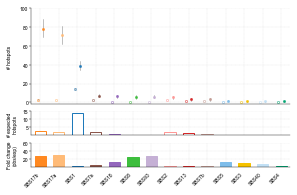

In [13]:
plt.rc('axes', edgecolor='black')
xmin = 0.5
xmax = 14.5
fig, ax = plt.subplots(
    3, 
    sharex='col', 
    figsize=(4.5, 2.75), 
     gridspec_kw={'height_ratios': [1, 0.25, 0.25]}
) 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.15)

## SUBPLOT 0 
axis_key = 0
sorted_sigs_top = sorted_sigs
sep = 0.15
for i, signature in enumerate(sorted_sigs_top, 1):  
    exp, e_error_min, e_error_max = expected['1000kb'][signature]
    obs, o_error_min, o_error_max = observed[signature]
    ax[axis_key].plot([i+sep, i+sep], [o_error_min, o_error_max], ls='-', lw=0.5, c='grey', zorder=1)
    ax[axis_key].scatter(i+sep, obs, color=sigs_color[signature], alpha=1, marker='o', s=5, lw=0.5, zorder=3)
    ax[axis_key].plot([i-sep, i-sep], [e_error_min, e_error_max], ls='-', lw=0.5, c='grey', zorder=1)
    ax[axis_key].scatter(i-sep, exp, color='white', marker='o', s=5, lw=0.5, edgecolor=sigs_color[signature])
    
ax[axis_key].set_xlim(xmin, xmax)
ax[axis_key].set_ylim(-2, 100)
ax[axis_key].set_yticks([0, 20, 40, 60, 80, 100])
ax[axis_key].set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=5)

## SUBPLOT 1 
axis_key = 1
xdata = []
ydata = []
colors = []
for i, signature in enumerate(sorted_sigs_top, 1):
    xdata += [i]
    ydata += [expected['1000kb'][signature][0]]
    colors += [sigs_color[signature]]
ax[axis_key].bar(xdata, ydata, width=0.60, color=['white']*len(xdata), edgecolor=colors)
ax[axis_key].set_ylim(0, 15)
ax[axis_key].set_yticks([5, 10, 15])
ax[axis_key].set_yticklabels([5, 10, 15])
ax[axis_key].set_xlim(xmin, xmax)

# SUBPLOT 2 
axis_key = 2
xdata = []
ydata = []
colors = []
for i, signature in enumerate(sorted_sigs_top, 1):
    xdata += [i]
    fc = fold_change[signature]
    ydata += [fc]
    colors += [sigs_color[signature]]
ax[axis_key].bar(xdata, ydata, width=0.60, color=colors, edgecolor=colors)
ax[axis_key].set_ylim(0, 60)
yticks = [20, 40, 60]
ax[axis_key].set_yticks(yticks)
ax[axis_key].set_yticklabels(yticks, fontsize=5)
ax[axis_key].set_xlim(xmin, xmax)

########### X axis
ax[axis_key].set_xticks(list(range(1, len(sorted_sigs) + 1)))
ax[axis_key].set_xticklabels(sorted_sigs, fontsize=6, rotation=45, ha='right')

########## Y axis
ylabels_dict = {
    0: '# hotspots', 
    1: '# expected\nhotspots',
    2: 'Fold change\n(obs/exp)'
}

for key, value in ylabels_dict.items(): 
    ax[key].set_axisbelow(True)
    ax[key].set_ylabel(value, fontsize=5, rotation=90, labelpad=10, va='center')
    ax[key].grid(color='lightgrey', linestyle='--', linewidth=0.25)
    for tick in ax[key].yaxis.get_major_ticks():
        tick.label.set_fontsize(5) 
    for tick in ax[key].xaxis.get_major_ticks():
            tick.label.set_fontsize(5) 
            
    for location in ['top', 'bottom', 'left', 'right']:
        ax[key].spines[location].set_linewidth(0.4)
        
    ax[key].tick_params(axis = "x", which = "both", bottom=False)
    ax[key].tick_params(axis = "y", which = "both", left=False)
    
    ax[key].tick_params(axis='both', which='major', pad=1) 
    ax[key].spines['right'].set_visible(False)
    ax[key].spines['top'].set_visible(False)
    
    ax[key].tick_params(axis = "x", which = "both", bottom=False)
    ax[key].tick_params(axis = "y", which = "both", left=True, width=0.4, length=2)

for extension in ['png']: 
    output = f'./fig_4D.{extension}'
    plt.savefig(output, bbox_inches='tight', dpi=350)

## Panel 4E

In [14]:
# Load data
sorted_sigs_top = sorted_sigs[:3]
binsizes = ['1000kb', '500kb', '250kb', '100kb', '50kb', '25kb', '10kb']
keys_plot = []
for sig in sorted_sigs_top: 
    for b in binsizes: 
        keys_plot.append((sig, b))
    keys_plot.append((sig, None))

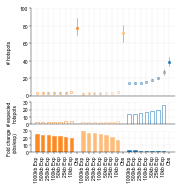

In [15]:
plt.rc('axes', edgecolor='black')
xmin = 0
xmax = 25
fig, ax = plt.subplots(
    3, 
    sharex='col', 
    figsize=(2.5, 2.5), 
     gridspec_kw={'height_ratios': [1, 0.25, 0.25]}
) 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.15)

## SUBPLOT 0 
axis_key = 0
sep = 0.15
for i, sig_bin in enumerate(keys_plot[:24], 1):
    signature, binsize = sig_bin
   
    if binsize: 
        exp, e_error_min, e_error_max = expected[binsize][signature]
        ax[axis_key].plot([i, i], [e_error_min, e_error_max], ls='-', lw=0.5, c='grey', zorder=1)
        ax[axis_key].scatter(i, exp, color='white', marker='o', s=5, lw=0.5, edgecolor=sigs_color[signature])
        
    else: 
        obs, o_error_min, o_error_max = observed[signature]
        ax[axis_key].plot([i, i], [o_error_min, o_error_max], ls='-', lw=0.5, c='grey', zorder=1)
        ax[axis_key].scatter(i, obs, color=sigs_color[signature], alpha=1, marker='o', s=6, lw=0.5, zorder=3)
    
ax[axis_key].set_xlim(xmin, xmax)
ax[axis_key].set_ylim(0, 100)
ax[axis_key].set_yticks([0, 20, 40, 60, 80, 100])
ax[axis_key].set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=5)

## SUBPLOT 1 
axis_key = 1
xdata = []
ydata = []
colors = []
for i, sig_bin in enumerate(keys_plot[:24], 1):
    signature, binsize = sig_bin
    if binsize:
        xdata += [i]
        ydata += [expected[binsize][signature][0]]
        colors += [sigs_color[signature]]
ax[axis_key].bar(xdata, ydata, width=0.60, color=['white']*len(xdata), edgecolor=colors, lw=0.5)
ax[axis_key].set_ylim(0, 30)
ax[axis_key].set_yticks([0, 10, 20, 30])
ax[axis_key].set_yticklabels([0, 10, 20, 30])
ax[axis_key].set_xlim(xmin, xmax)

# SUBPLOT 2 
axis_key = 2
xdata = []
ydata = []
colors = []
for i, sig_bin in enumerate(keys_plot[:24], 1):
    signature, binsize = sig_bin
    if binsize: 
        xdata += [i]
        fc = observed[signature][0]/expected[binsize][signature][0]
        ydata += [fc]
        colors += [sigs_color[signature]]
ax[axis_key].bar(xdata, ydata, width=0.60, color=colors, edgecolor=colors, lw=0.5)
ax[axis_key].set_ylim(0, 30)
yticks = [0, 10, 20, 30]
ax[axis_key].set_yticks(yticks)
ax[axis_key].set_yticklabels(yticks, fontsize=5)
ax[axis_key].set_xlim(xmin, xmax)

########### X axis
ax[axis_key].set_xticks(list(range(1, len(keys_plot[:24]) + 1)))
labels = [f'{b} Exp' if b else f'Obs' for s, b in keys_plot[:24]]
ax[axis_key].set_xticklabels(labels, fontsize=5, rotation=90, ha='center')

########## Y axis
ylabels_dict = {
    0: '# hotspots', 
    1: '# expected\nhotspots',
    2: 'Fold change\n(obs/exp)'
}

for key, value in ylabels_dict.items(): 
    ax[key].set_axisbelow(True)
    ax[key].set_ylabel(value, fontsize=5, rotation=90, labelpad=10, va='center')
    ax[key].grid(color='lightgrey', linestyle='--', linewidth=0.25)
    for tick in ax[key].yaxis.get_major_ticks():
        tick.label.set_fontsize(5) 
    for tick in ax[key].xaxis.get_major_ticks():
            tick.label.set_fontsize(5) 
            
    for location in ['top', 'bottom', 'left', 'right']:
        ax[key].spines[location].set_linewidth(0.4)
        
    ax[key].tick_params(axis = "x", which = "both", bottom=False)
    ax[key].tick_params(axis = "y", which = "both", left=False)
    
    ax[key].tick_params(axis='both', which='major', pad=1) 
    ax[key].spines['right'].set_visible(False)
    ax[key].spines['top'].set_visible(False)
    
    ax[key].tick_params(axis = "x", which = "both", bottom=False)
    if key == 2: 
        ax[key].tick_params(axis = "x", which = "both", bottom=True, width=0.4, length=2)
    ax[key].tick_params(axis = "y", which = "both", left=True, width=0.4, length=2)

for extension in ['png']: 
    output = f'./fig_4E.{extension}'
    plt.savefig(output, bbox_inches='tight', dpi=350)

## Panel 4F

In [16]:
# Compute gaps between observed and expected
# Here we use different expected models, starting with the homogeneous distribution of trinucleotide-specific 
# mutation rates, followed by the different models including regional mutation rate variability from 1 Mbp to 10 Kbp
lines = []
header = ['SIG', 'H_OBS', 'TRI']
for i, binsize in enumerate(['1000kb', '500kb', '250kb', '100kb', '50kb', '25kb', '10kb']):
    header += [f'MEGA_{binsize}', f'MEGA_{binsize}_GAIN']
header.append('MISSING')
    
for sig in sorted_sigs: 
    
    subline = [sig]
        
    # Observed
    observed_sig = observed[sig][0]
    subline.append(observed_sig)
    
    # Trinucleotide model (homogeneous mutation rate)
    exp_tri_sig = expected_tri[sig]
    # Compute fraction (%) of observed that is accounted for by the expected
    f_exp_tri = 100 * exp_tri_sig / observed_sig
    subline.append(f_exp_tri)
    
    # Megabase and submegabase models (regional mutation rate variability)
    pre_model = f_exp_tri
    for i, binsize in enumerate(['1000kb', '500kb', '250kb', '100kb', '50kb', '25kb', '10kb']):
               
        exp_mega_sig = expected[binsize][sig][0]
        # Compute fraction (%) of observed that is accounted for by the expected
        f_exp_mega = 100 * exp_mega_sig / observed_sig
        
        # Gain (substract fraction expected by the previous model)
        gain = f_exp_mega - pre_model
        gain = 0 if gain < 0 else gain
        pre_model = f_exp_mega
        
        subline += [f_exp_mega, gain]
    
    # Missing (fraction of observed unexplained by the expected)
    miss = 100 - f_exp_mega
    subline.append(miss)
    
    lines.append(pd.DataFrame([subline]))
    
df = pd.concat(lines)
df.columns = header
df

,SIG,H_OBS,TRI,MEGA_1000kb,MEGA_1000kb_GAIN,MEGA_500kb,MEGA_500kb_GAIN,MEGA_250kb,MEGA_250kb_GAIN,MEGA_100kb,MEGA_100kb_GAIN,MEGA_50kb,MEGA_50kb_GAIN,MEGA_25kb,MEGA_25kb_GAIN,MEGA_10kb,MEGA_10kb_GAIN,MISSING
0,SBS17b,78.0,2.319447,3.910948,1.591501,4.132805,0.221857,4.272209,0.139404,4.393524,0.121315,4.504698,0.111175,4.689445,0.184747,5.211184,0.521738,94.788816
0,SBS17a,72.0,1.776172,3.456812,1.680640,3.659667,0.202855,3.794713,0.135045,3.966537,0.171825,4.191042,0.224504,4.609280,0.418238,5.831638,1.222358,94.168362
0,SBS1,39.0,30.363387,35.883552,5.520165,36.939516,1.055964,38.137224,1.197708,41.267766,3.130541,45.138059,3.870293,51.017921,5.879862,68.309095,17.291174,31.690905
0,SBS7a,7.0,22.525859,31.453622,8.927763,33.273816,1.820194,34.622766,1.348950,35.650074,1.027307,36.102648,0.452574,36.446597,0.343949,36.962225,0.515628,63.037775
0,SBS18,7.0,5.481312,9.220751,3.739439,9.552916,0.332165,9.761626,0.208710,9.985317,0.223691,10.225213,0.239896,10.651269,0.426056,11.851652,1.200383,88.148348
0,SBS8,6.0,2.907731,4.007170,1.099439,4.147385,0.140215,4.250715,0.103330,4.414352,0.163637,4.631788,0.217436,5.048266,0.416478,6.269761,1.221495,93.730239
0,SBS93,6.0,2.683471,3.736926,1.053455,3.828739,0.091812,3.895224,0.066485,4.001164,0.105939,4.146160,0.144997,4.420598,0.274438,5.223855,0.803257,94.776145
0,SBS2,6.0,37.406543,40.152459,2.745916,40.461217,0.308758,40.889678,0.428461,42.031252,1.141574,43.749431,1.718179,47.133582,3.384151,56.698179,9.564597,43.301821
0,SBS13,4.0,33.543903,34.843262,1.299359,35.071052,0.227790,35.445834,0.374782,36.448324,1.002490,37.997302,1.548978,40.995609,2.998308,49.662147,8.666537,50.337853
0,SBS7b,3.5,30.842165,34.944653,4.102488,35.862417,0.917764,36.619283,0.756866,37.557976,0.938693,38.439020,0.881044,39.879981,1.440961,43.794729,3.914748,56.205271


In [17]:
df[['SIG', 'H_OBS', 'MEGA_10kb', 'MISSING']]

,SIG,H_OBS,MEGA_10kb,MISSING
0,SBS17b,78.0,5.211184,94.788816
0,SBS17a,72.0,5.831638,94.168362
0,SBS1,39.0,68.309095,31.690905
0,SBS7a,7.0,36.962225,63.037775
0,SBS18,7.0,11.851652,88.148348
0,SBS8,6.0,6.269761,93.730239
0,SBS93,6.0,5.223855,94.776145
0,SBS2,6.0,56.698179,43.301821
0,SBS13,4.0,49.662147,50.337853
0,SBS7b,3.5,43.794729,56.205271


In [18]:
min(df['MISSING'].tolist()), max(df['MISSING'].tolist())

(31.69090523421835, 94.78881628106618)

In [19]:
# Color palette
gradient = sns.color_palette("YlOrRd", 7)
model_color = {}
model_color['TRI'] = '#d49b6bff'
model_color['MISSING'] = '#dedddaff'
for binsize, color in list(zip(binsizes, gradient)): 
    model_color[f'MEGA_{binsize}'] = color

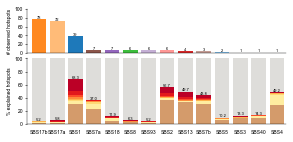

In [20]:
fig, ax = plt.subplots(
    2, 
    sharex='col', 
    figsize=(4.5, 2), 
     gridspec_kw={'height_ratios': [1, 1.5]}
) 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.1)

## SUBPLOT 0 
axis_key = 0
sigs_to_plot = sorted_sigs
y = []
colors = []
for i, sig in enumerate(sorted_sigs):
    data = df.loc[df['SIG'] == sig]
    y += [data['H_OBS'].iloc[0]]
    colors += [sigs_color[sig]]
    
    # Annotate 
    yloc = data['H_OBS'].iloc[0]
    ax[axis_key].annotate(s=int(yloc), xy=(i, yloc+0.5), xytext=(i, yloc+0.5),fontsize=4, color='black', ha='center')

# Barplot 
ax[axis_key].bar(sigs_to_plot, y, width=0.8, bottom=None, color=colors, align='center', alpha=1)

ax[axis_key].set_ylim(0, 100)
ax[axis_key].set_yticks([0, 20, 40, 60, 80, 100])
ax[axis_key].set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=5)
ax[axis_key].set_xlim(-0.65, 13.5)

# SUBPLOT 1 
axis_key = 1
y_data = defaultdict(list)
for i, sig in enumerate(sigs_to_plot):
    data = df.loc[df['SIG'] == sig]
    y_data['TRI'] += [data['TRI'].iloc[0]]
    for binsize in binsizes: 
        y_data[f'MEGA_{binsize}'] += [data[f'MEGA_{binsize}_GAIN'].iloc[0]]
    y_data['MISSING'] += [data['MISSING'].iloc[0]]
    
    # Annotate 
    yloc = data['MEGA_10kb'].iloc[0]
    ax[axis_key].annotate(s=f'{round(yloc, 1)}', xy=(i, yloc+0.5), xytext=(i, yloc+0.5),fontsize=4, color='black', ha='center')
    
bottom = None
for model in ['TRI'] + [f'MEGA_{binsize}' for binsize in binsizes] + ['MISSING']: 
    ax[axis_key].bar(sigs_to_plot, y_data[model], width=0.8, bottom=bottom, color=model_color[model], align='center', alpha=1, lw=0)
    if not bottom: 
        bottom = y_data[model]
    else: 
        bottom = [bottom[i] + y_data[model][i] for i in range(len(bottom))]
        
ax[axis_key].set_ylim(0, 100)
ax[axis_key].set_yticks([0, 20, 40, 60, 80, 100])
ax[axis_key].set_xlim(-0.65, 13.5)
ax[axis_key].set_xticklabels(sigs_to_plot, fontsize=5, rotation=0, ha="center")

########### X axis
ax[axis_key].set_xticklabels(sigs_to_plot, fontsize=5, rotation=0)

######### Y axis
ylabels_dict = {
    0: '# observed hotspots', 
    1: '% explained hotspots'
}

for key, value in ylabels_dict.items(): 
    ax[key].set_axisbelow(True)
    ax[key].set_ylabel(value, fontsize=5, rotation=90, labelpad=5, va='center')
    for tick in ax[key].yaxis.get_major_ticks():
        tick.label.set_fontsize(5) 
    for tick in ax[key].xaxis.get_major_ticks():
        tick.label.set_fontsize(5) 
            
    for location in ['top', 'bottom', 'left', 'right']:
        ax[key].spines[location].set_linewidth(0.4)
        
    ax[key].tick_params(axis = "x", which = "both", bottom=False)
    ax[key].tick_params(axis = "y", which = "both", left=True, width=0.5, length=2)
    
    ax[key].tick_params(axis='both', which='major', pad=2) 
    ax[key].spines['right'].set_visible(False)
    ax[key].spines['top'].set_visible(False)

for extension in ['png']: 
    output = f'./fig_4F.{extension}'
    plt.savefig(output, bbox_inches='tight', dpi=350)